# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.2: Covariance and Correlation

### 1.2.3 Lagged Correlation /  Cross correlation


The correlation of two variables is an incredibly useful metric, however it has a severe limitation, particularly in many time series values.

We would investigate the correlation if we expect a causation (note that we cannot prove causation) between $X$ and $Y$, that is, we expect that if we change $X$ then we cause a change in $Y$. An example of such a hypothesis would be "if we spend more money on advertising, our sales will increase". We can affect advertising spend, which we assume in turn will cause an increase in sales.

However, the problem with determining this correlation is that advertising spend does not *immediately* affect sales. Instead, there is a period of time, a **lag**, between the spending and the sales increase. At the very least, people need time to get to the store!

Computing this **lagged correlation** is a normal task, and a common one when analysing time series data. Another phrase for this term is **cross-correlation**, with a lag $k$.

On terminology, if $X$ "happens first", we say it *leads* $Y$. If $Y$ "happens first", then $X$ *lags* $Y$. In many programming functions, the term used is simply "lag", and a negative lag value means a lead. Be careful with this though - some programs will only consider "lead", and positive values indicate this. Always check the documentation!

In [1]:
%run setup.ipy

### Investigating Cross Correlation

Let's have a look at an example. One might suspect that interest rate is a leading indicator of inflation. If interest rates are lower, then they spend more, leading to the inflation. 

<div class="alert alert-danger">
    In this section we will manually compute the lag and then the correlation. In practice, do not do this and see the next section for methods that do this for you. "Stand on the shoulders of giants", and tend to use existing libraries rather than rewriting core components of your program from scratch.
</div>

Let's look at some data:

In [2]:
import quandl
interest_rates = quandl.get("RBA/F13_FOOIRATCR")

In [3]:
interest_rates.columns = ["Cash Rate"]

<Axes: xlabel='Date'>

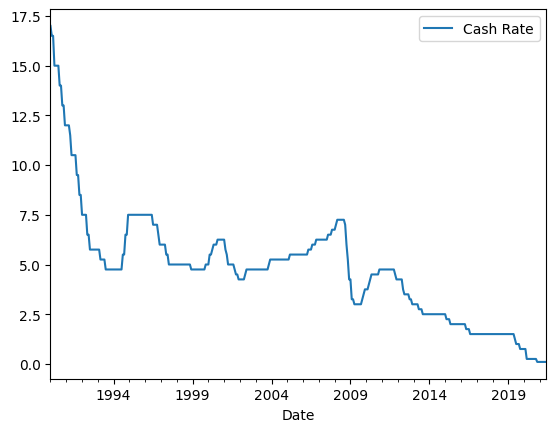

In [4]:
interest_rates.plot()

In [5]:
inflation = quandl.get("RBA/G01_GCPIAGSAQP")
inflation.columns = ['Inflation']

<Axes: xlabel='Date'>

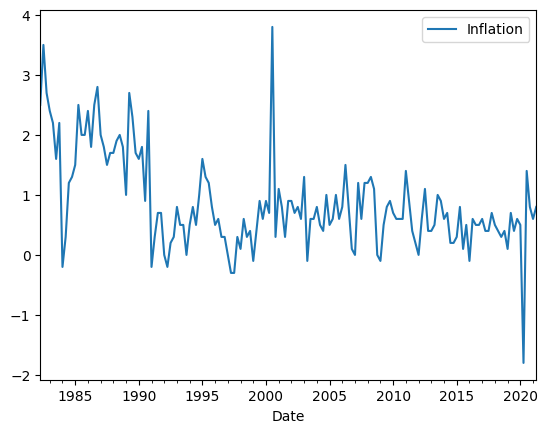

In [6]:
inflation.plot()

In [7]:
combined = inflation.join(interest_rates).dropna()  # Join by index, drop missing data

In [8]:
combined

,Inflation,Cash Rate
Date,,
1990-03-31,1.6,16.50
1990-06-30,1.8,15.00
1990-09-30,0.9,14.00
1990-12-31,2.4,12.00
1991-03-31,-0.2,12.00
...,...,...
2020-06-30,-1.8,0.25
2020-09-30,1.4,0.25
2020-12-31,0.8,0.10


<Axes: xlabel='Date'>

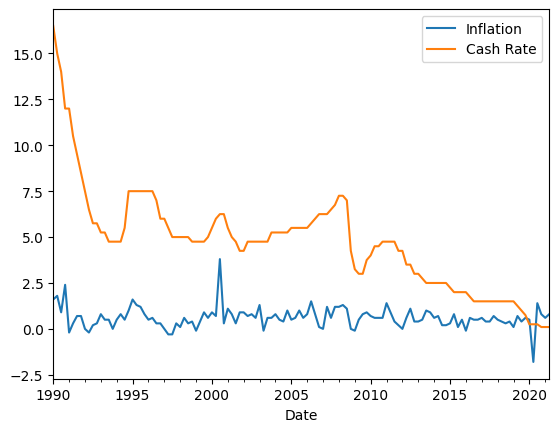

In [9]:
combined.plot()

Before we comput the correlation, we need to normalise. To do this, we will change the values from absolute values to the difference from the previous record:

In [10]:
combined = combined.pct_change()

<Axes: xlabel='Date'>

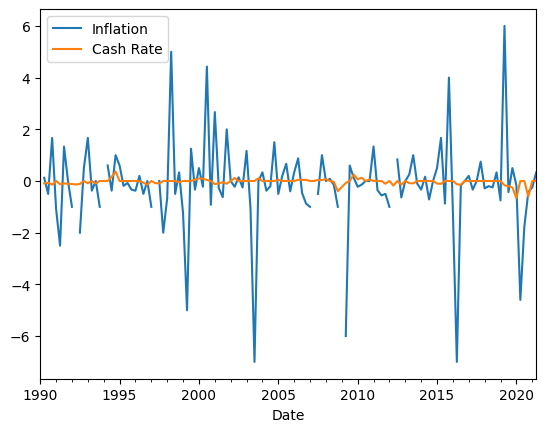

In [11]:
combined.plot()

Directly, the correlation is not that strong:

In [14]:
combined.corr().loc[('Cash Rate', "Inflation")]

0.02442223237001552

However, if we add a "lagged inflation" value, we get a stronger correlation:

In [15]:
combined['Lagged Inflation'] = combined['Inflation'].shift(2)

In [16]:
combined.head()

,Inflation,Cash Rate,Lagged Inflation
Date,,,
1990-03-31,NaN,NaN,NaN
1990-06-30,0.125000,-0.090909,NaN
1990-09-30,-0.500000,-0.066667,NaN
1990-12-31,1.666667,-0.142857,0.125
1991-03-31,-1.083333,0.000000,-0.500


In [17]:
combined.corr().loc[('Cash Rate', "Inflation")]

0.02442223237001552

In [42]:
combined.corr().loc['Cash Rate', "Lagged Inflation"]

-0.03506348228551407

<Axes: xlabel='Date'>

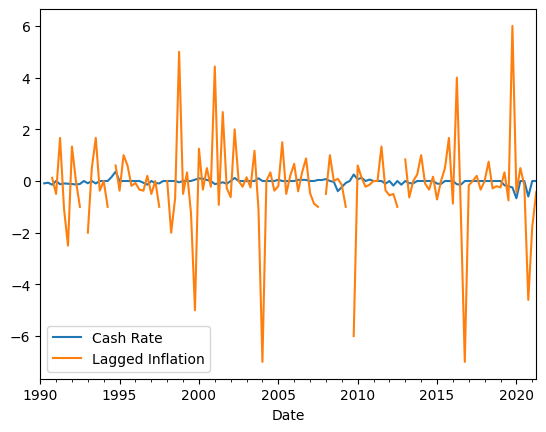

In [19]:
combined[['Cash Rate', 'Lagged Inflation']].plot()

Not only has the scale of the correlation increased, the sign has swapped! Note, if you choose different lag periods, you will get quite different answers. Further, the economy is much more complex than a single causal relationship - there will be other factors that alter impact of the Cash rate on the inflation, so it is not a single one-to-one relationship.

#### Exercise

Compute the following graph, which has the lag value as the x-axis, and the correlation as the y-axis.

<img src='img/lagged_correlation_plot.png'>

Note also that there is a spike in the -1 to -3 lag period - what does this mean?

Note that when you pull down your data, your time period will differ to the one used to create this image. Therefore, your results will vary, slightly, from mine. If you are unsure of your solution, rerun the provided solution for an "up to date" plot.

In [21]:
lags

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

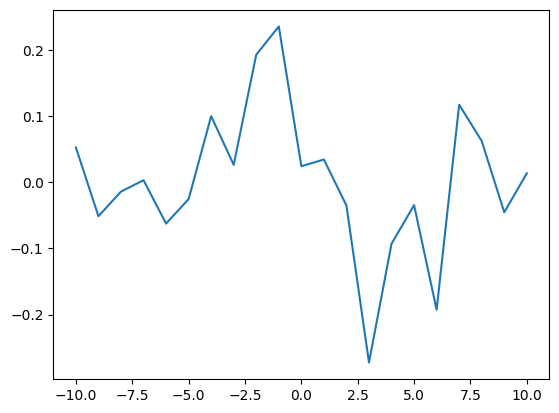

In [43]:
lags = np.linspace(-10,10,21)
lagged_corrs = []

for lag in lags:
    combined['Inflation lagged'] = combined['Inflation'].shift(int(lag))
    lagged_corrs.append(combined[["Cash Rate",'Inflation lagged']].corr().iloc[0,1])

plt.plot(lags.tolist(), lagged_corrs, "-")

*For solutions, see `solutions/lagged_correlations.py`*

### Computing Cross Correlation


In [44]:
import statsmodels.tsa.stattools as ts

In [45]:
combined.replace([np.inf, -np.inf], np.nan, inplace=True)

In [46]:
combined.dropna(inplace=True)

In [47]:
combined.head()

,Inflation,Cash Rate,Lagged Inflation,Inflation lagged
Date,,,,
1993-03-31,1.666667,-0.086957,-2.000000,-0.500000
1993-06-30,-0.375000,0.000000,0.500000,1.666667
1993-09-30,0.000000,-0.095238,1.666667,-1.083333
1993-12-31,-1.000000,0.000000,-0.375000,-2.500000
1994-06-30,0.600000,0.000000,-1.000000,0.000000


In [48]:
ccf = ts.ccf(combined['Cash Rate'], combined['Inflation'])

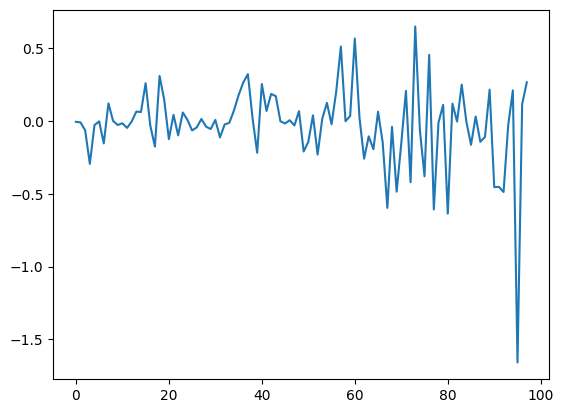

In [50]:
plt.plot(ccf)

A good rule of thumb is that a correlation is significant if it is higher than $\frac{2}{\sqrt{n - |k|}}$, where $n$ is the number of datapoints, and $|k|$ is the lag:

(-1.0, 1.0)

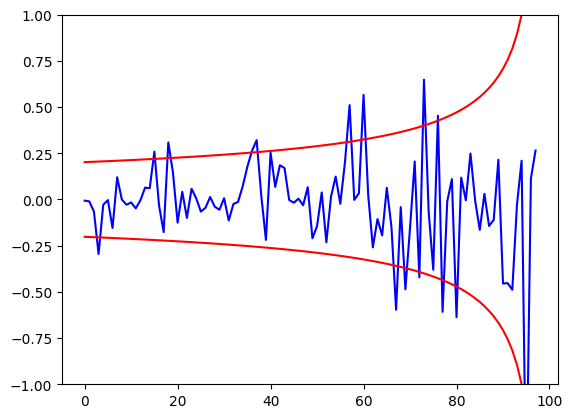

In [51]:
n = len(combined)
x = np.arange(0, n)
threshold_positive = 2 / np.sqrt(n - x)
threshold_negative = 2 / -np.sqrt(n - x)

plt.plot(ccf, 'b')
plt.plot(threshold_positive, 'r')
plt.plot(threshold_negative, 'r')
plt.ylim(-1, 1)

We can see "significant" peaks at 20, 36 and 40. I put significant in quotes here - this is just a rule of thumb, and should be tested more robustly. Further, we haven't checked our assumptions about the data that are necessary for such a test.

In [54]:
np.where(ccf > threshold_positive)[0]  # np.where tells us the index where a test is true.

array([15, 18, 36, 37, 57, 60, 73, 76], dtype=int64)

In [55]:
np.where(ccf < threshold_negative)[0]

array([ 3, 67, 69, 72, 77, 80, 95], dtype=int64)

### Requirements and assumptions

Cross correlation tests have important assumptions that must be adhered to.

* No autocorrelation
* Time series are stationarity

We will examine both of these concepts, and how to test for them.

### Autocorrelation

Autocorrelation is the rate at which a series of data (usually time series) correlates with itself (specifically, itself with lag). An example of this is a time series where one value is dependent on the previous version:

In [59]:
# Here is a completely random series, it should not depend on itself, and therefore should not have any autocorrelation
random_values = [0]

for i in range(100):
    # Just a random value
    random_values.append(np.random.random() - 0.5)

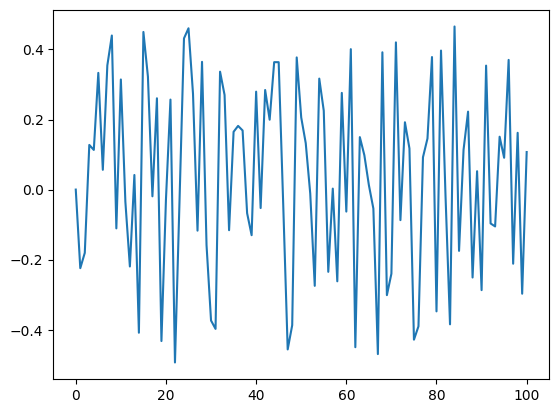

In [60]:
plt.plot(random_values)

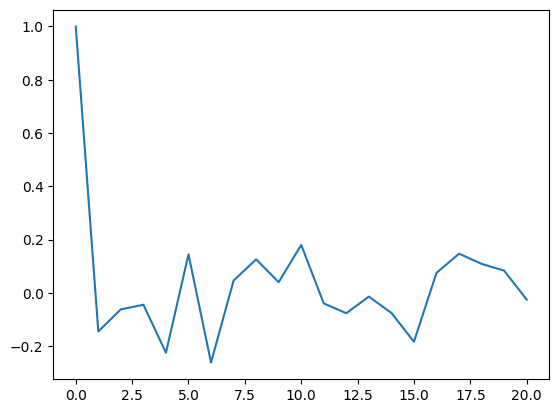

In [61]:
# Compute autocorrelation values, which are the correlation of x with itself, lagged
plt.plot(ts.acf(random_values))

In the above graph, we see the values correlate exactly with itself with no lag - unsurprising!

However, after this, any other lag value has a near-zero correlation, indicating no correlation between the values and the lagged version.

Let's now create a time series with dependency.

In [62]:
# Here is an example where value (n) is dependent on value (n-1)
values = [0]

for i in range(100):
    # Add a random value to the previous value. While the values are random, they are random, but biased
    values.append(np.random.random() - 0.5 + values[-1])

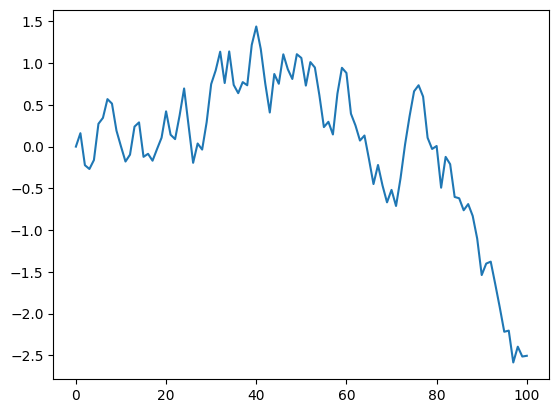

In [63]:
plt.plot(values)

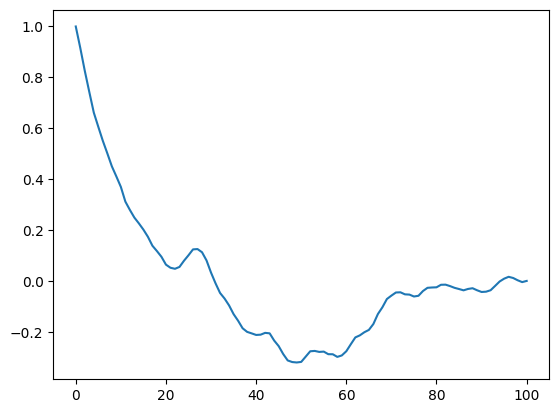

In [79]:
plt.plot(ts.acf(values, nlags=100))

In this example, the values are correlated with itself (as per the definition of correlation), but the correlation stays high as the lag increases. This shows that the values are dependent on themselves.

If your data is autocorrelated, you should remove this before computing cross correlation with other time series. You can remove autocorrelation with a process known as pre-whitening, which removes the autocorrelation.

An example of a method for this is Holt Winters. Techniques like this are also known as smoothing algorithms, but that term has multiple meanings, and smoothing algorithms have multiple uses.

In [66]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [67]:
model = SimpleExpSmoothing(values)

In [68]:
model_fit = model.fit()

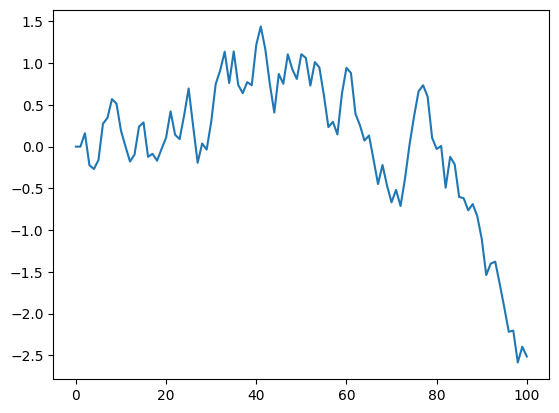

In [69]:
plt.plot(model_fit.fittedvalues)

#### Exercises

1. Review the documentation on the Smoothing algorithms from https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html See also the "Next" link to the left to view more algorithms.
2. Check the autocorrelation for two currencies from Quandl (try the BUNDESBANK data source)
3. Using a smoothing (whitening) algorithm, smooth the values of those currencies and check for autocorrelations in the results

In [75]:
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

C:\Users\Luke\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Luke\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


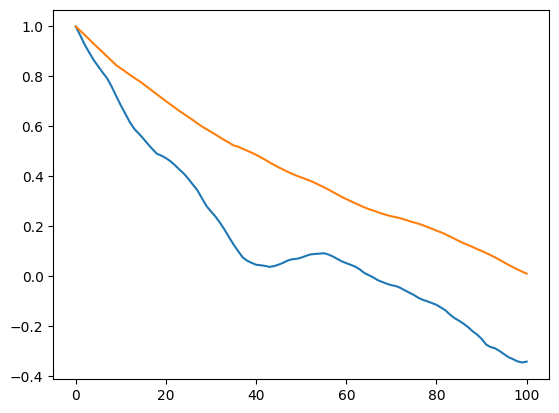

In [81]:
#ExponentialSmoothing?

euro = quandl.get("BUNDESBANK/BBEX3_M_AUD_EUR_CM_AC_A01")  # Euros in AUD

euros = euro['Value']
euros.name = "EURO"
euros.head()

usd = quandl.get("BUNDESBANK/BBEX3_M_AUD_USD_CM_AC_A01")['Value']
usd.name = "USD"
usd.head()

#ExponentialSmoothing?

euro_model = SimpleExpSmoothing(euros)
euro_fit = euro_model.fit()
plt.plot(ts.acf(euro_fit.fittedvalues, nlags=100))

usd_model = SimpleExpSmoothing(usd)
usd_fit = usd_model.fit()
plt.plot(ts.acf(usd_fit.fittedvalues, nlags=100))


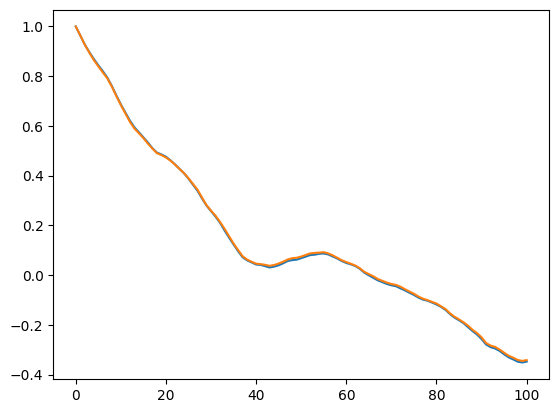

In [82]:
plt.figure()
plt.plot(ts.acf(euros, nlags=100))
plt.plot(ts.acf(euro_fit.fittedvalues, nlags=100))

*For solutions, see `solutions/exponential_smoothing.py`*

### Stationarity

A stationary dataset is one where the main statistics are consistent throughout the given data, usually the mean and standard deviation. For instance, a time series with inflation would not be stationary, as it tends to grow overtime:

In [83]:
import quandl

In [84]:
platinum_prices = quandl.get("LPPM/PLAT")['USD AM']

<Axes: xlabel='Date'>

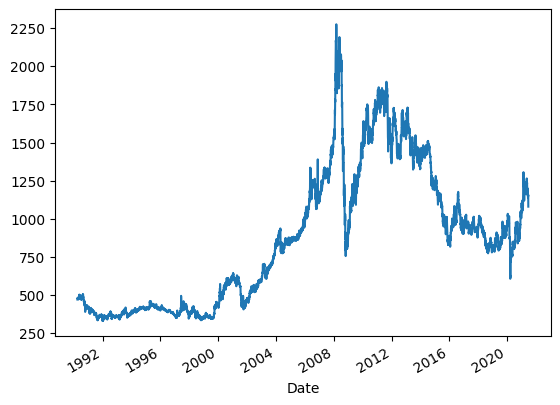

In [85]:
platinum_prices.plot()

If we plot the moving average, we can see it tends to increase:

<Axes: xlabel='Date'>

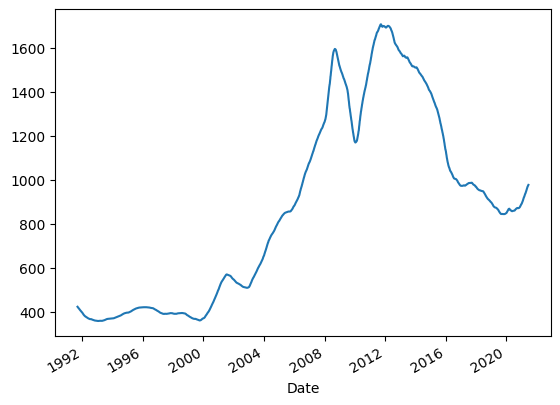

In [87]:
platinum_prices.rolling(365).mean().dropna().plot()  # Rolling n day window

We can see here that the mean is not consistent over time. This data is not stationary, which we can test more formally:

In [88]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(platinum_prices)
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))

ADF Statistic: -1.67
p-value: 0.45


If the p-value is less than a given threshold (for instance 0.05) we would reject the hypothesis of a "unit root" and declare the dataset as stationary. Let's do the same test with our random values from before

In [89]:
result = adfuller(random_values)
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))

ADF Statistic: -6.28
p-value: 0.00


We can see here a p-value of (near) zero, which we would expect in this data as it has no time dependent structure.

#### Exercises

1. Compute the `adfuller` statistic for the currencies you extracted from Quandl earlier.
2. A simple method of transforming data to be stationary is to compute the difference to the previous value. Difference your data to obtain a stationary dataset.
3. Another method to create stationary data is transform the data using a log function. Compute the log of the currencies and recompute the adfuller statistic.

In [95]:
# Question 1
euro_result = adfuller(euro_fit.fittedvalues)
print('ADF Statistic: {:.2f}'.format(euro_result[0]))
print('p-value: {:.2f}'.format(euro_result[1]))

usd_result = adfuller(usd_fit.fittedvalues)
print('ADF Statistic: {:.2f}'.format(usd_result[0]))
print('p-value: {:.2f}'.format(usd_result[1]))


# Question 2
euro_diff = euros.diff()
result = adfuller(euro_diff[~np.isnan(euro_diff)])
print(result[1])

usd_diff = usd.diff()
result = adfuller(usd_diff[~np.isnan(usd_diff)])
print(result[1])
# Question 3 

euro_log = np.log(euros)
result = adfuller(euro_log[~np.isnan(euro_log)])
print(result[1])
usd_log = np.log(usd)
result = adfuller(usd_log[~np.isnan(usd_log)])
print(result[1])


ADF Statistic: -2.32
p-value: 0.17
ADF Statistic: -3.13
p-value: 0.02
7.793750190917808e-29
0.0
0.13930134139064038
0.08026183374552143


*For solutions, see `solutions/adfuller.py`*

### CAPM - Capital Asset Pricing Model

The CAPM model is a widely used model to determine expected returns for an asset and the impact of systematic risk. One method for calculating systematic risk is to measure the correlation between a stock and the market in general.

The CAPM model is:


$ \bar{R_a} = R_f + \beta (\bar{R_m} - R_f)$

Where:

* $\bar{R_a}$ is the expected return of the investment
* $R_f$ is the risk free rate
* $\beta$ is the Beta of the investment (see below)
* $\bar{R_m}$ is the expected return of the market

Note that the value $(\bar{R_m} - R_f)$ is also known as the market risk premium.

The Beta of an investment is the volatility of the stock, in relation to the market. If the stock moves with the market, it has a Beta around 1.0 (the market itself has, by definition, a Beta of 1.0). Stocks with low Beta values have less risk. High Beta values have high risk.

To compute Beta, the equation is:

$\beta = \frac{cov(a, m)}{var(m)}$

Where $var(m)$ is the variance of the market, and $cov(a, m)$ is the covariance between the market and the given asset.

#### Extended Exercise

1. Download the S&P 500 data from Quandl. Use the dataset search to find an appropriate data source.
2. Compute the percentage change on a daily basis as a value between 0 and 100% - not a decimal. You'll need the closing price.
3. Repeat steps 1 and 2 for a given stock (the provided solution uses Coca Cola)
4. Compute the Beta value, using the prices for the period 2016 to 2018 inclusive
5. Compute the CAPM value, with a risk free rate of 2.5% (or another if you have a preferred risk free investment). Hint: CAGR

In [98]:
sp500

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1982-04-21,116.35,117.60,116.05,117.45,NaN,117.45,3696.0,412.0
1982-04-22,117.00,118.40,117.00,117.90,NaN,117.90,2827.0,719.0
1982-04-23,118.40,119.75,118.25,119.65,NaN,119.65,2933.0,946.0
1982-04-26,119.30,120.60,118.65,120.55,NaN,120.55,2871.0,1084.0
1982-04-27,120.20,120.35,118.40,118.85,NaN,118.85,3854.0,1142.0
...,...,...,...,...,...,...,...,...
2021-06-23,NaN,4247.20,4231.60,NaN,-4.8,4231.40,2210.0,6989.0
2021-06-24,NaN,4261.40,NaN,NaN,24.7,4256.10,1640.0,8667.0
2021-06-25,NaN,4273.90,4254.60,NaN,15.2,4271.30,3080.0,9518.0


In [97]:
sp500_sample

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2016-01-04,2037.9,2042.4,1981.0,2009.5,26.3,2009.1,20229.0,80698.0
2016-01-05,2010.0,2016.8,1992.6,2011.7,2.6,2011.7,6417.0,93272.0
2016-01-06,2011.9,2012.6,1971.3,1986.5,25.8,1985.9,7025.0,93768.0
2016-01-07,1987.0,1990.5,1929.2,1932.0,53.0,1932.9,9484.0,92642.0
2016-01-08,1933.0,1964.4,1910.0,1912.0,21.4,1911.5,6905.0,94807.0
...,...,...,...,...,...,...,...,...
2018-12-24,2405.8,2433.9,2340.0,2340.0,71.8,2341.7,3021.0,24504.0
2018-12-26,2348.8,2477.0,2317.1,2473.0,129.2,2470.9,10538.0,26931.0
2018-12-27,2469.0,2498.0,2397.5,2495.0,24.0,2494.9,3198.0,32418.0


In [100]:
market

Date
2016-01-05    0.109480
2016-01-06   -1.252672
2016-01-07   -2.743519
2016-01-08   -1.035197
2016-01-11    0.125523
                ...   
2018-12-24   -5.759162
2018-12-26    5.683761
2018-12-27    0.889608
2018-12-28   -0.360721
2018-12-31    1.045857
Name: Last, Length: 736, dtype: float64

In [96]:
sp500 = quandl.get("CHRIS/CME_SP1")

sp500_sample = sp500.loc["2016":"2018"].dropna()

market = sp500_sample['Last'].pct_change().dropna() * 100

cola = quandl.get("WIKI/KO")

cola_sample = cola['2016':"2018"]

coca = cola_sample['Close'].pct_change().dropna() * 100

market_variance = market["2016":"2018"].var()
print(f"Market Variance: {market_variance}")

stock_cov = market.corr(coca)

print(f"Stock Covariance: {stock_cov}")

beta = stock_cov / market_variance

print(f"Beta: {beta}")

e = ending_balance = sp500_sample.iloc[-1]["Last"]
s = starting_balance = sp500_sample.iloc[0]["Last"]
n = number_years = 3  # 2016, 2017, 2018
return_on_market = (e / s) ** (1 / n) - 1

print(f"Return on Market: {return_on_market}")

capm = .025  + beta * (return_on_market - .025)
print(f"CAPM: {capm}")


Market Variance: 0.7265414157716945
Stock Covariance: 0.4684920443273424
Beta: 0.6448249668323925
Return on Market: 0.0772352134654195
CAPM: 0.058682569790322076


*For solutions, see `solutions/capm.py`*